<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Посмотрим-тренды-и-сезонность" data-toc-modified-id="Посмотрим-тренды-и-сезонность-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Посмотрим тренды и сезонность</a></span></li><li><span><a href="#Посмотрим-тренды-и-сезонность-на-данных-свернутых-по-дням" data-toc-modified-id="Посмотрим-тренды-и-сезонность-на-данных-свернутых-по-дням-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Посмотрим тренды и сезонность на данных свернутых по дням</a></span></li><li><span><a href="#Скользящее-среднее" data-toc-modified-id="Скользящее-среднее-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Скользящее среднее</a></span></li><li><span><a href="#Очистим-данные-от-дневной-и-недельной-цикличности" data-toc-modified-id="Очистим-данные-от-дневной-и-недельной-цикличности-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Очистим данные от дневной и недельной цикличности</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Создадим-признаки" data-toc-modified-id="Создадим-признаки-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Создадим признаки</a></span></li><li><span><a href="#Простая-модель" data-toc-modified-id="Простая-модель-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Простая модель</a></span></li><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#Линейная-регрессия-Ridge" data-toc-modified-id="Линейная-регрессия-Ridge-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Линейная регрессия Ridge</a></span></li><li><span><a href="#Линейная-регрессия-Ridge-2" data-toc-modified-id="Линейная-регрессия-Ridge-2-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Линейная регрессия Ridge 2</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Нужно построить модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

План:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

In [1]:
# импорты из стандартной библиотеки
import warnings

# импорты сторонних библиотек
import numpy as np
import pandas as pd

# для построения графиков
import seaborn as sns
import matplotlib.pyplot as plt

#!pip install statsmodels

# импорты модулей текущего проекта
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import (
    mean_squared_error, 
    make_scorer
)
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    TimeSeriesSplit
)
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import (
    LinearRegression,
    Ridge
)
from sklearn.preprocessing import StandardScaler

# настройки
warnings.filterwarnings("ignore")

#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10,5

# константы заглавными буквами
RANDOM_STATE_MODEL = 34770

## Подготовка

In [2]:
try:
    data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', 
                         index_col=[0], parse_dates=[0])

print("Посмотрим пропуски")
print(data.isna().mean())    
print()
    
data.sort_index(inplace=True)

# ресемплирование по одному часу
data = data.resample('1H').sum()

data.info()

Посмотрим пропуски
num_orders    0.0
dtype: float64

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


Пропусков нет.
<br>Одна колонка, название нормальное.

In [3]:
data.sample(5)

,num_orders
datetime,
2018-05-20 11:00:00,51
2018-03-10 00:00:00,117
2018-08-08 02:00:00,157
2018-05-03 16:00:00,104
2018-06-25 06:00:00,50


In [4]:
data.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


В максимуме аномалии?

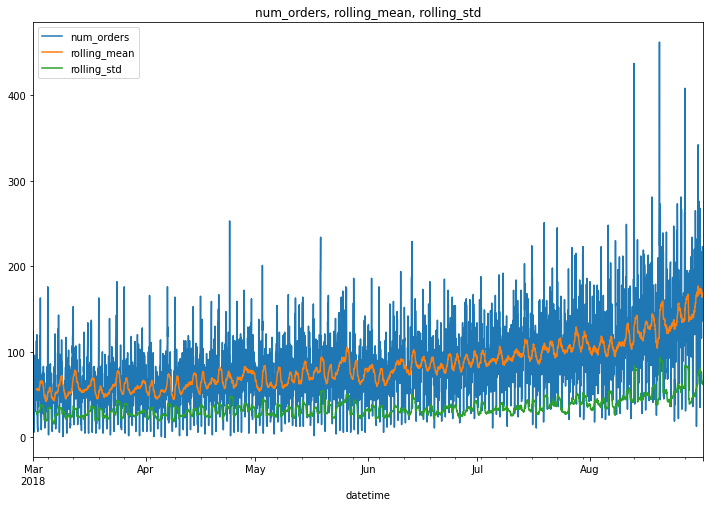

In [5]:
plt.figure(figsize=(12, 8))

data.plot(ax=plt.gca());
data['num_orders'].rolling(24).mean().plot(ax=plt.gca());
data['num_orders'].rolling(24).std().plot(ax=plt.gca());

plt.title('num_orders, rolling_mean, rolling_std')

ax=plt.gca()
ax.legend(labels=['num_orders','rolling_mean', 'rolling_std']);

## Анализ

### Посмотрим тренды и сезонность

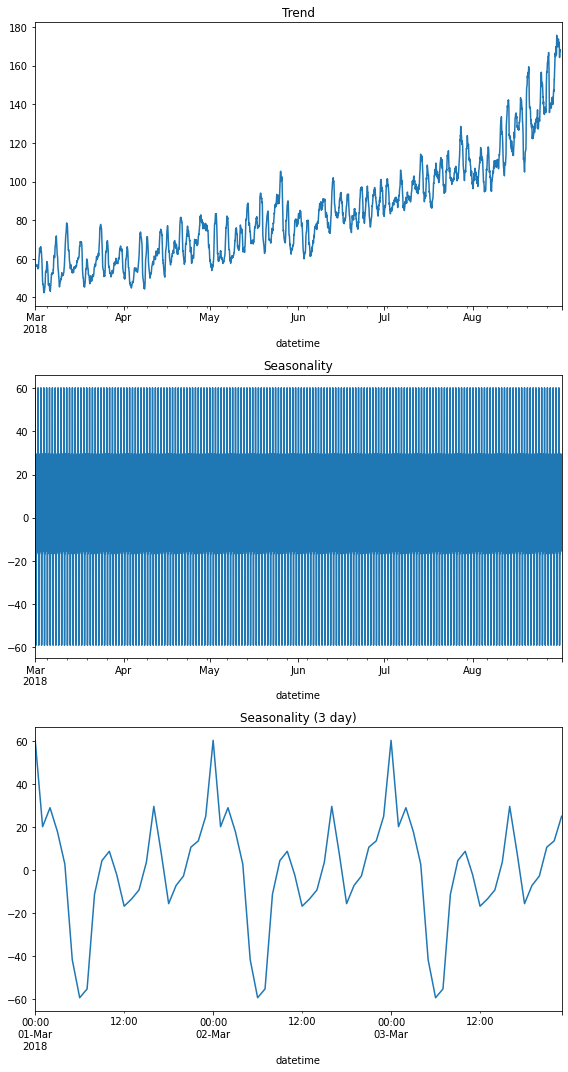

In [6]:
decomposed = seasonal_decompose(data) 

plt.figure(figsize=(8, 15))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

# # график сезонной составляющей за период 3 дня
plt.subplot(313)
decomposed.seasonal[:3*24].plot(ax=plt.gca())
plt.title('Seasonality (3 day)')

plt.tight_layout()

- Основной тренд на рост
- В рамках 24-х часов сезонность:
    - До 6 утра спад.
    - До 11 рост.
    - До 12 спад.
    - До 3-х рост.
    - До 5-ти спад.
    - До полуночи рост.
- Нужно схлопнуть на день и посмотреть сезонность.

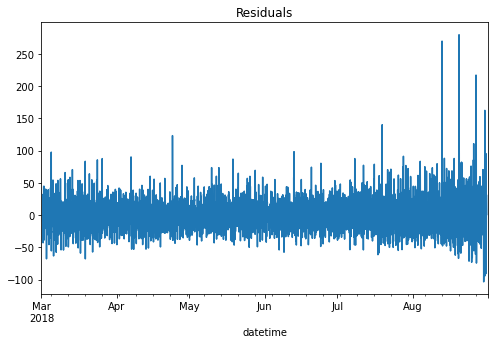

In [7]:
plt.figure(figsize=(8, 5))

decomposed.resid.plot(ax=plt.gca());
plt.title('Residuals');

Остаток декомпозиции в основном в рамках (-50, +50), существенные значения.

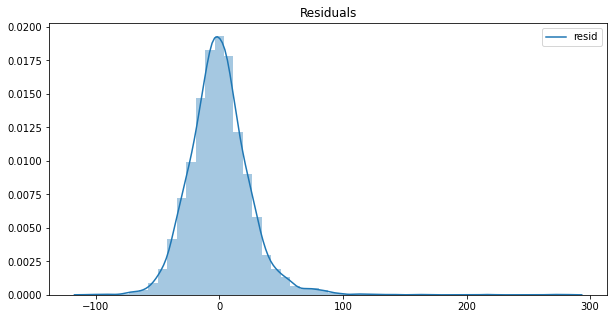

In [8]:
decomposed.resid.describe()

ax = sns.distplot(decomposed.resid)
ax.set_title('Residuals');
ax.set_ylabel('');
ax.set_xlabel('');   
ax.legend(labels=['resid']);
plt.show()

Похоже нормальное распределение, с аномалиями.

Метрика RMSE

In [9]:
# Метрика RMSE
def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred)**0.5
    
rmse_scorer = make_scorer(rmse, greater_is_better=False)

Посмотрим ошибку разложения тренд, сезонность, остаток.

In [10]:
temp = decomposed.trend + decomposed.seasonal + decomposed.resid
temp = temp[12:-12]
print("MAE выборки:", rmse(data[12:-12], temp))
del temp

MAE выборки: 2.2193942227609824e-15


Ошибка не значительная по сравнению с порогом 48.
<br>Можно попробовать использовать для моделирования.

Какая ошибка если убрать остаток.

In [11]:
temp = decomposed.trend + decomposed.seasonal
temp = temp[12:-12]
print(f"MAE выборки: {rmse(data[12:-12], temp):.04f}", )
del temp

MAE выборки: 24.6941


Ошибка ниже порога 48, если убрать остаток.

Что будет если ограничить разброс остатка.

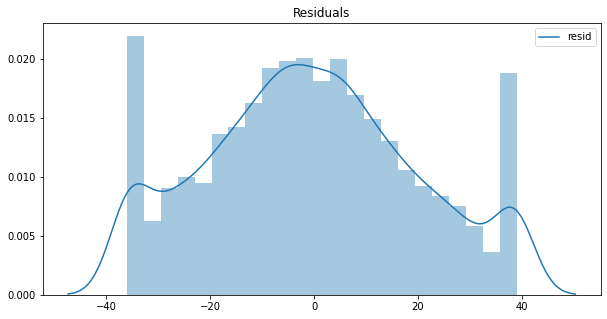

In [12]:
resid = decomposed.resid.copy()
# 10%
qu_left, qu_right = resid.quantile(0.05), resid.quantile(0.95)

resid = resid.apply(lambda a: qu_left if a<qu_left else a)
resid = resid.apply(lambda a: qu_right if a>qu_right else a)

ax = sns.distplot(resid)
ax.set_title('Residuals');
ax.set_ylabel('');
ax.set_xlabel('');   
ax.legend(labels=['resid']);
plt.show()

In [13]:
temp = decomposed.trend + decomposed.seasonal + resid
temp = temp[12:-12]
print(f"MAE выборки: {rmse(data[12:-12], temp):.04f}", )
del temp

MAE выборки: 8.9532


Ошибка при обрезанном остатке хуже чем просто остаток и лучше чем без остатка декомпозиции.

Если только остаток и цикличность.

In [14]:
temp = (
    decomposed.seasonal[12:-12] + 
    decomposed.resid[12:-12]
)
print(f"MAE выборки: {rmse(data[12:-12], temp):.04f}")
del temp

MAE выборки: 88.2809


MAE выборки: 88.2809
<br>Только остатки и цикличности не достаточно что бы не выйти за порог 48.

### Посмотрим тренды и сезонность на данных свернутых по дням

In [15]:
data_day = data.resample('1D').sum()
decomposed_day = seasonal_decompose(data_day)

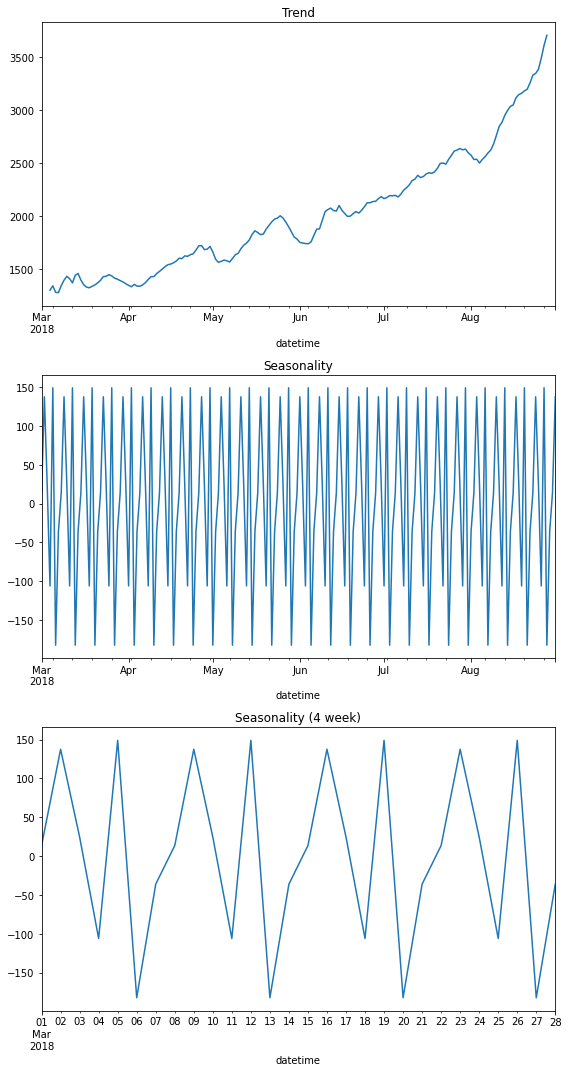

In [16]:
plt.figure(figsize=(8, 15))
plt.subplot(311)
decomposed_day.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed_day.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

# график сезонной составляющей за период 4 недели
plt.subplot(313)
decomposed_day.seasonal[:7*4].plot(ax=plt.gca())
plt.title('Seasonality (4 week)')

plt.tight_layout()

- Тренд более монотонный, основной на рост.
- Сезонность в рамках недели:
    - Падение с пятницы по воскресение.
    - С воскресения на понедельник рост.
    - С понедельника на вторник спад.
    - Потом со вторника до пятницы рост.

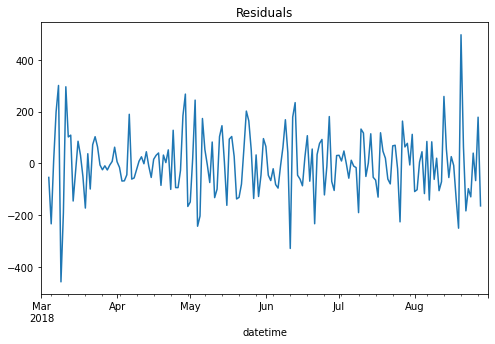

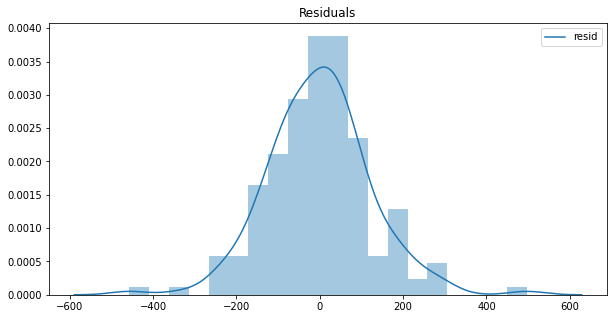

In [17]:
plt.figure(figsize=(8, 5))

decomposed_day.resid.plot(ax=plt.gca());
plt.title('Residuals');
plt.show()

ax = sns.distplot(decomposed_day.resid)
ax.set_title('Residuals');
ax.set_ylabel('');
ax.set_xlabel('');   
ax.legend(labels=['resid']);
plt.show()

Остаток декомпозиции не выглядит как не значительный.

In [18]:
temp = decomposed_day.trend + decomposed_day.seasonal + decomposed_day.resid
temp = temp[12:-12]
print("MAE выборки:", rmse(data_day[12:-12], temp))

MAE выборки: 3.113442275577916e-14


Ошибка не значительная по сравнению с порогом 48.
<br>Можно попробовать использовать для моделирования.

### Скользящее среднее

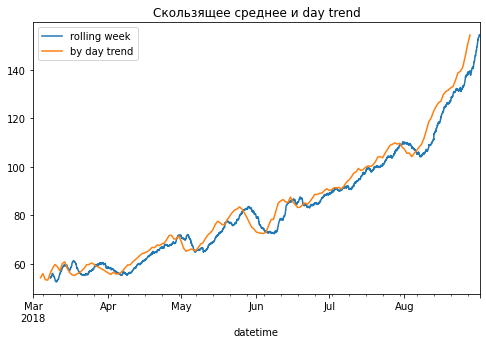

In [19]:
plt.figure(figsize=(8, 5))

# Одна неделя со сдвигом 1 час
data_rolling = data.shift().rolling(24*7).mean()[24*7:]
data_rolling.plot(ax=plt.gca());
(decomposed_day.trend/24.0).plot(ax=plt.gca())
plt.title('Скользящее среднее и day trend');

ax=plt.gca()
ax.legend(labels=['rolling week','by day trend']);

plt.show()

Посмотрим остаток если убрать полученное скользящее среднее.

In [20]:
data_tail = data[24*7:].copy()
data_tail['num_orders'] =data_tail['num_orders'] - data_rolling['num_orders']
decomposed_tail = seasonal_decompose(data_tail)

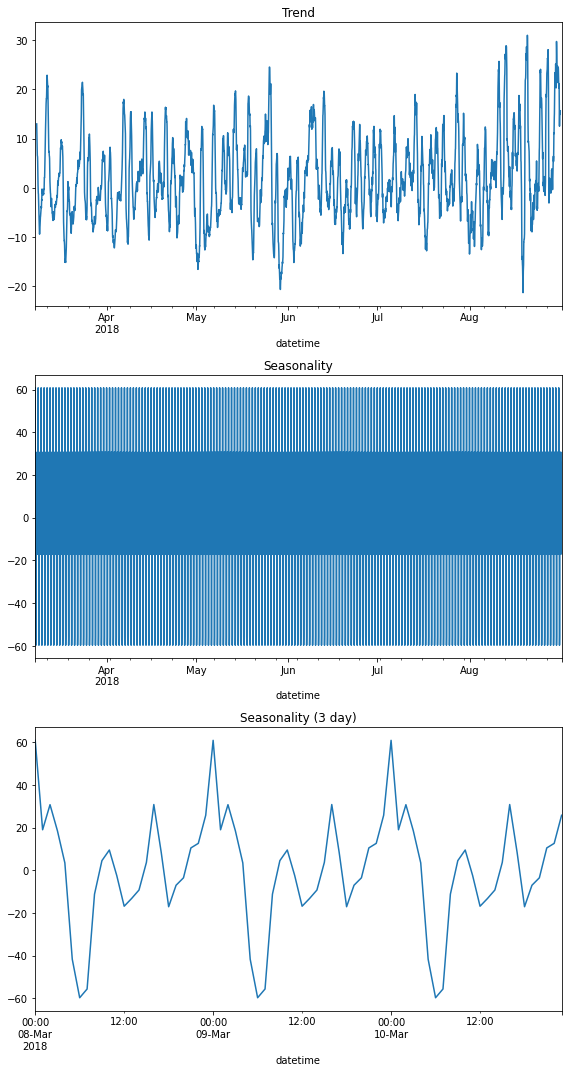

In [21]:
plt.figure(figsize=(8, 15))
plt.subplot(311)
decomposed_tail.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed_tail.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

# график сезонной составляющей за период 3 дня
plt.subplot(313)
decomposed_tail.seasonal[:24*3].plot(ax=plt.gca())
plt.title('Seasonality (3 day)')

plt.tight_layout()

Возможно в тренде недельная сезонность.
<br>Сезонность в рамках дня сохранилась.

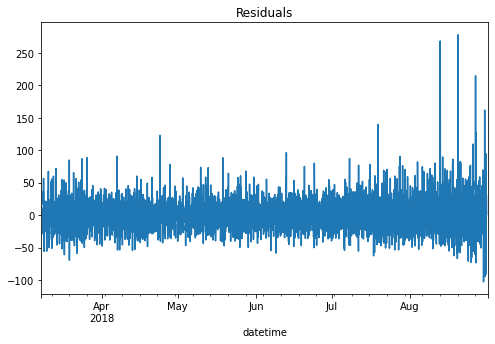

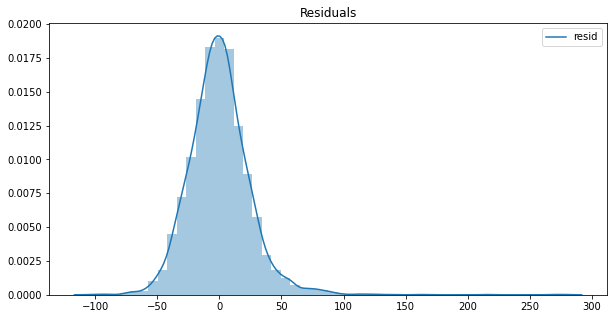

In [22]:
plt.figure(figsize=(8, 5))

decomposed_tail.resid.plot(ax=plt.gca());
plt.title('Residuals');
plt.show()

ax = sns.distplot(decomposed_tail.resid)
ax.set_title('Residuals');
ax.set_ylabel('');
ax.set_xlabel('');   
ax.legend(labels=['resid']);
plt.show()

Похоже остаток тоже сохранился.

Посмотрим ошибку с использованием скользящего среднего.

In [23]:
temp = (
    data_rolling[12:-12]['num_orders'] + 
    decomposed_tail.trend[12:-12] + 
    decomposed_tail.seasonal[12:-12] + 
    decomposed_tail.resid[12:-12]
)
print("MAE выборки:", rmse(data[24*7+12:-12], temp))
del temp

MAE выборки: 5.909992539966196e-15


Ошибка по сравнению с порогом в 48 не значительная.

Что будет если убрать тренд.

In [24]:
temp = (
    data_rolling[12:-12]['num_orders'] + 
    decomposed_tail.seasonal[12:-12] + 
    decomposed_tail.resid[12:-12]
)
print(f"MAE выборки: {rmse(data[24*7+12:-12], temp):.04f}")
del temp

MAE выборки: 8.9108


Порог ошибки в 48 не превышен, есть хороший запас.

Что будет если оставить скользящее среднее и сезонность.

In [25]:
temp = data_rolling[12:-12]['num_orders'] + decomposed_tail.seasonal[12:-12]
print(f"MAE выборки: {rmse(data[24*7+12:-12], temp):.04f}")
del temp

MAE выборки: 26.7495


Порог ошибки в 48 не превышен.

Что будет если сезонность взять из начальной декомпозиции.

In [26]:
temp = data_rolling[12:-12]['num_orders'] + decomposed.seasonal[24*7+12:-12]
print(f"MAE выборки: {rmse(data[24*7+12:-12], temp):.04f}")
del temp

MAE выборки: 26.7597


Порог ошибки в 48 не превышен.
<br> Нужно попробовать моделировать используя скользящее среднее за неделю со сдвигом на час и сезонность в рамках дня.

### Очистим данные от дневной и недельной цикличности

In [27]:
data_clean = data.copy()
# дневная цикличность
data_clean['num_orders'] = data_clean['num_orders']-decomposed.seasonal

# недельная цикличность
seasonal_day = pd.DataFrame(np.NaN, columns = data.columns, index = data.index)
seasonal_day['num_orders'] = decomposed_day.seasonal/24.0
seasonal_day = seasonal_day.fillna(method = 'ffill')
data_clean['num_orders'] = data_clean['num_orders'] - seasonal_day['num_orders'] 

decomposed_clean = seasonal_decompose(data_clean)

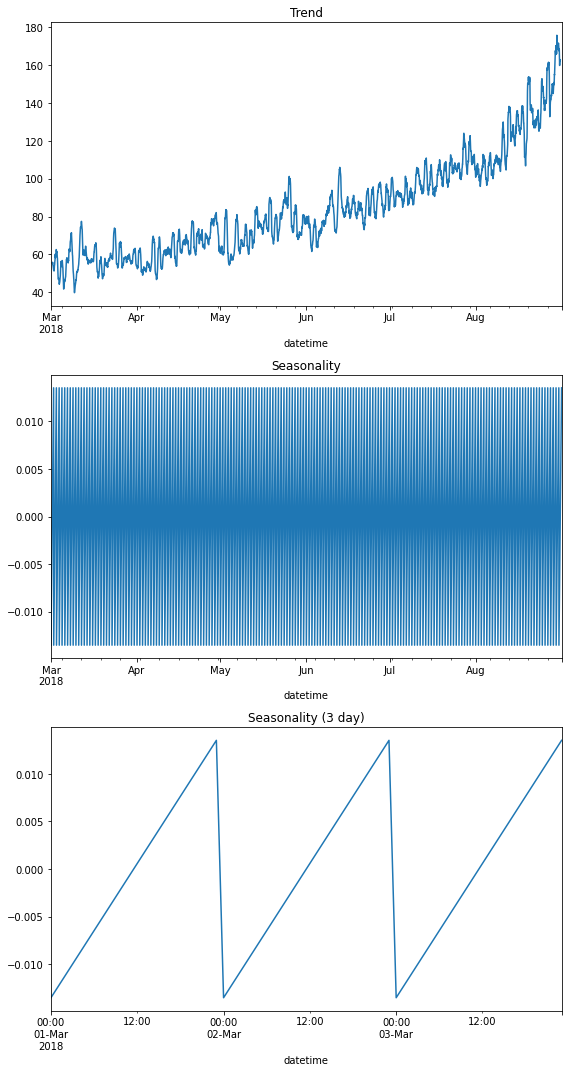

In [28]:
plt.figure(figsize=(8, 15))
plt.subplot(311)
decomposed_clean.trend.plot(ax=plt.gca())
#plt.ylim(-20, 180)
plt.title('Trend')

plt.subplot(312)
decomposed_clean.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

# график сезонной составляющей за период 3 day
plt.subplot(313)
decomposed_clean.seasonal[:24*3].plot(ax=plt.gca())
plt.title('Seasonality (3 day)')

plt.tight_layout()

Удалось убрать дневную цикличность.

Используем скользящее среднее за неделю со сдвигом на час.

In [29]:
data_rolling = data_clean.shift().rolling(24*7).mean()[24*7:]

Посмотрим ошибку с учетом очистки от цикличности.

In [30]:
temp = (
    data_rolling[12:-12]['num_orders'] + 
    decomposed.seasonal[24*7+12:-12] + 
    seasonal_day[24*7+12:-12]['num_orders']+ 
    decomposed_clean.resid[24*7+12:-12] 
)
print(f"MAE выборки: {rmse(data[24*7+12:-12], temp):.04f}")
del temp

MAE выборки: 7.8497


Порог ошибки в 48 не превышен, есть хороший запас.
- без очистки MAE выборки: 8.9108
- с очисткой MAE выборки: 7.8497

С обрезанным остатком.

In [31]:
temp = (
    data_rolling[12:-12]['num_orders'] + 
    decomposed.seasonal[24*7+12:-12] + 
    seasonal_day[24*7+12:-12]['num_orders'] + 
    resid[24*7+12:-12]
)
print(f"MAE выборки: {rmse(data[24*7+12:-12], temp):.04f}")
del temp

MAE выборки: 12.7367


Порог ошибки в 48 не превышен.

Если отбросить недельную цикличность.

In [32]:
temp = (
    data_rolling[12:-12]['num_orders'] + 
    decomposed.seasonal[24*7+12:-12] + 
    resid[24*7+12:-12]
)
print(f"MAE выборки: {rmse(data[24*7+12:-12], temp):.04f}")
del temp

MAE выборки: 13.3417


При пороге 48 можно отбросить.

Посмотрим ошибку только на скользящем среднем с очисткой и дневной цикличности.

In [33]:
temp = (
    data_rolling[12:-12]['num_orders'] + 
    decomposed.seasonal[24*7+12:-12]
)
print(f"MAE выборки: {rmse(data[24*7+12:-12], temp):.04f}")
del temp

MAE выборки: 26.7597


С точностью до 4-го знака совпадает с результатом без очистки скользящего среднего.

**Итого**
- Основной тренд на рост
- В рамках 24-х часов сезонность:
    - До 6 утра спад.
    - До 11 рост.
    - До 12 спад.
    - До 3-х рост.
    - До 5-ти спад.
    - До полуночи рост.
- Сезонность в рамках недели:
    - Падение с пятницы по воскресение.
    - С воскресения на понедельник рост.
    - С понедельника на вторник спад.
    - Потом со вторника до пятницы рост.    
- Нужно попробовать моделировать используя скользящее среднее за неделю со сдвигом на час и сезонность в рамках дня.
    - При этом на всех данных MAE такой выборки: 26.7597
        - Что ниже установленного порога в 48.
- Можно попробовать моделировать остаток декомпозиции
    - При его учете как есть MAE на всей выборке: 13.3417

## Обучение

### Создадим признаки

In [34]:
def make_features(data, max_lag, rolling_mean_size):
        
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    # Скользящее среднее за неделю со сдвигом в один час
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    data['rolling_dlt'] = data['rolling_mean']-data['rolling_mean'].shift()

In [35]:
make_features(data, 1, 24*7)

Разделим выборку на части.

In [36]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()
train, valid = train_test_split(train, shuffle=False, test_size=0.2)

X_train, y_train = train.drop('num_orders', axis = 1), train['num_orders']
X_valid, y_valid = valid.drop('num_orders', axis = 1), valid['num_orders']
X_test, y_test = test.drop('num_orders', axis = 1), test['num_orders']

print('Интервалы дат:')
print('\t тренировочная\t', X_train.index.min(), '|', X_train.index.max())
print('\t валидация\t', X_valid.index.min(), '|', X_valid.index.max())
print('\t тестовая\t', X_test.index.min(), '|', y_test.index.max())

Интервалы дат:
	 тренировочная	 2018-03-08 01:00:00 | 2018-07-12 20:00:00
	 валидация	 2018-07-12 21:00:00 | 2018-08-13 13:00:00
	 тестовая	 2018-08-13 14:00:00 | 2018-08-31 23:00:00


Цикличность в рамках дня.

In [37]:
# Цикличность в рамках дня на тестовой
X_train['seasonal_hour'] = seasonal_decompose(y_train).seasonal

In [38]:
# Продлим цикличность с тренировочной на вариационную и тестовую
X_valid['seasonal_hour'] = pd.Series(
    data = X_train['seasonal_hour'].values[
        X_valid.index[0].hour-X_train.index[0].hour:len(X_valid)+
            X_valid.index[0].hour-X_train.index[0].hour],
    index = X_valid.index
)

X_test['seasonal_hour'] = pd.Series(
    data = X_train['seasonal_hour'].values[
        X_test.index[0].hour-X_train.index[0].hour:len(X_test)+
            X_test.index[0].hour-X_train.index[0].hour],
    index = X_test.index
)

Проверим что цикличность продлена верно.

In [39]:
display(X_test['seasonal_hour'].head())
display(X_train[X_test.index[0].hour-1:]['seasonal_hour'].head())

datetime
2018-08-13 14:00:00    -5.919415
2018-08-13 15:00:00     4.304460
2018-08-13 16:00:00    28.820664
2018-08-13 17:00:00     0.448144
2018-08-13 18:00:00   -12.649243
Freq: H, Name: seasonal_hour, dtype: float64

datetime
2018-03-08 14:00:00    -5.919415
2018-03-08 15:00:00     4.304460
2018-03-08 16:00:00    28.820664
2018-03-08 17:00:00     0.448144
2018-03-08 18:00:00   -12.649243
Freq: H, Name: seasonal_hour, dtype: float64

Цикличность продлена верно.

Проверим что цикличность продлена верно.

In [40]:
display(X_valid['seasonal_hour'].head())
display(X_train[X_valid.index[0].hour-1:]['seasonal_hour'].head())

datetime
2018-07-12 21:00:00    10.909123
2018-07-12 22:00:00    17.105717
2018-07-12 23:00:00    24.931114
2018-07-13 00:00:00    54.791233
2018-07-13 01:00:00    14.050657
Freq: H, Name: seasonal_hour, dtype: float64

datetime
2018-03-08 21:00:00    10.909123
2018-03-08 22:00:00    17.105717
2018-03-08 23:00:00    24.931114
2018-03-09 00:00:00    54.791233
2018-03-09 01:00:00    14.050657
Freq: H, Name: seasonal_hour, dtype: float64

Цикличность продлена верно.

### Простая модель

In [41]:
model = DummyRegressor(strategy = 'median')

model.fit(X_train, y_train)
y_prob = model.predict(X_valid)

print(f"MAE выборки: {rmse(y_valid, y_prob):.02f}")

MAE выборки: 55.76


MAE выборки:55.76

### Линейная регрессия

In [42]:
model = LinearRegression()

model.fit(X_train, y_train)
y_prob = model.predict(X_valid)

print(f"MAE выборки: {rmse(y_valid, y_prob):.04f}")

MAE выборки: 30.5736


MAE выборки: 30.5736

### Линейная регрессия Ridge

In [43]:
%%time

scaler = StandardScaler()
scaler.fit(X_train)

best_score = 50.0
best_alpha = 1.0
for ind in range(1, 100):
    model = Ridge(alpha = ind*0.01)
    model.fit(scaler.transform(X_train), y_train)
    y_prob = model.predict(scaler.transform(X_valid))
    score = rmse(y_valid, y_prob)
    if best_score>score:
        best_score = score
        best_alpha = ind*0.1
print(f"MAE выборки: {best_score:.04f}")
print('  при best_alpha = ', best_alpha)
print()

MAE выборки: 30.5736
  при best_alpha =  0.1

CPU times: user 608 ms, sys: 278 ms, total: 886 ms
Wall time: 872 ms


MAE выборки: 30.5736

**Итого**
- С точностью до 4-го знака ошибка на линейных регрессиях одинаковая

### Линейная регрессия Ridge 2

In [44]:
%time

X = pd.concat([X_train, X_valid])
y = pd.concat([y_train, y_valid])

scaler = StandardScaler()
scaler.fit(X)

param_search = {'alpha': [0.1*a for a in range(1, 100)]}

tscv = TimeSeriesSplit(n_splits=10)
gsearch = GridSearchCV(
    estimator=Ridge(), 
    cv=tscv, 
    param_grid=param_search, 
    scoring = rmse_scorer,
    n_jobs = -1
)
gsearch.fit(scaler.transform(X), y)

print(f"MAE Кросс валидация: {-gsearch.best_score_:.04f}")
print(gsearch.best_params_)

CPU times: user 6 µs, sys: 1 µs, total: 7 µs
Wall time: 6.2 µs
MAE Кросс валидация: 24.0807
{'alpha': 2.3000000000000003}


Посмотрим ошибку на валидационной выборке.
<br> Что бы сравнить все модели нужно сделать на кросс валидации

In [45]:
model = Ridge(alpha = gsearch.best_params_['alpha'])

model.fit(scaler.transform(X_train), y_train)
y_prob = model.predict(scaler.transform(X_valid))

print(f"MAE выборки: {rmse(y_valid, y_prob):.04f}")

MAE выборки: 30.5782


## Тестирование

In [46]:
X = pd.concat([X_train, X_valid])
y = pd.concat([y_train, y_valid])
scaler = StandardScaler()
scaler.fit(X)

model = Ridge(alpha = best_alpha)
model.fit(scaler.transform(X), y)

y_prob_test = model.predict(scaler.transform(X_test))
print(f"MAE выборки: {rmse(y_test, y_prob_test):.02f}")

MAE выборки: 42.02


MAE выборки: 42.02 ниже порога 48.

Попробуем простое сложение скользящего среднего и цикличности в рамках дня.

In [47]:
print("MAE выборки:", 
      f"{rmse(y_test, X_test['rolling_mean']+X_test['seasonal_hour']):.02f}")

MAE выборки: 45.01


MAE выборки: 45.01 ниже порога 48.

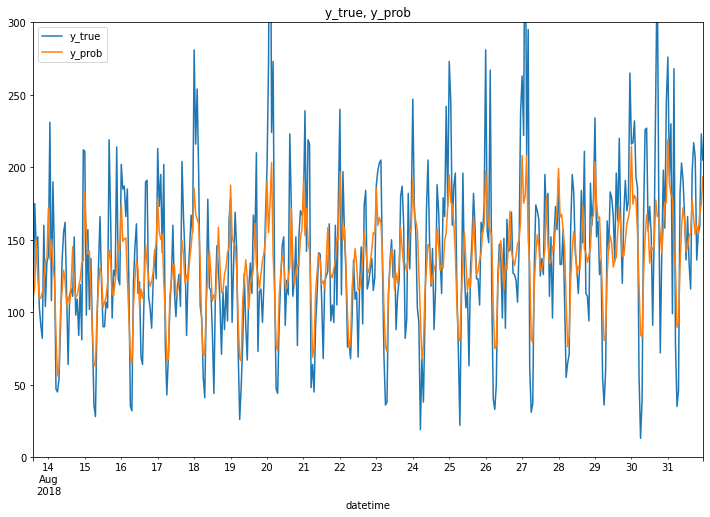

In [48]:
plt.figure(figsize=(12, 8))

y_test.plot(ax=plt.gca());
pd.Series(y_prob_test, index = y_test.index).plot(ax=plt.gca());

plt.title('y_true, y_prob')
plt.ylim(0, 300)

ax=plt.gca()
ax.legend(labels=['y_true','y_prob']);

## Общий вывод

**Анализ**
- Основной тренд на рост
- В рамках 24-х часов сезонность:
    - До 6 утра спад.
    - До 11 рост.
    - До 12 спад.
    - До 3-х рост.
    - До 5-ти спад.
    - До полуночи рост.
- Сезонность в рамках недели:
    - Падение с пятницы по воскресение.
    - С воскресения на понедельник рост.
    - С понедельника на вторник спад.
    - Потом со вторника до пятницы рост.    
- **Нужно попробовать моделировать используя скользящее среднее за неделю со сдвигом на час и сезонность в рамках дня**.
    - При этом на всех данных MAE такой выборки: 26.7597
        - Что ниже установленного порога в 48.
- Можно попробовать моделировать остаток декомпозиции
    - При его учете как есть MAE на всей выборке: 13.3417

**Обучение**
- С точностью до 4-го знака ошибка на линейных регрессиях одинаковая 

**Тестирование**
- На тестовой выборке MAE: 42.02 что ниже порога 48.
    - Простое сложение скользящего среднего и цикличности в рамках дня MAE: 45.01

**Пути улучшения**
- Найти хорошую модель для основного тренда 
- Попробовать моделировать остаток декомпозиции
- Попробовать учесть недельную цикличность
- Исключить из скользящего среднего влияние дневной и недельной цикличности